In [1]:
'''
TODO: PREPROCESSING
    - Generate masks from json files.
    - Add image_path, mask_path, json_path and background path to database.
    - Load them into list of tuples in the format of numpy array from database and shuffle.
    - Augment images and append to list.
    - Split into train and val data.
    - Train images using U-net segmentation model.
'''


'\nTODO: PREPROCESSING\n    - Generate masks from json files.\n    - Add image_path, mask_path, json_path and background path to database.\n    - Load them into list of tuples in the format of numpy array from database and shuffle.\n    - Augment images and append to list.\n    - Split into train and val data.\n    - Train images using U-net segmentation model.\n'

In [2]:
import os
import numpy as  np
import matplotlib.pyplot as plt
import json
import config
from matplotlib.path import Path
import cv2
from dataset import *
from model import *
from dataset.augment import *


In [3]:
'''
Generate masks from json files and store in mask folder
# '''
# count = 0
# for file in os.listdir(config.IMAGE_DIRECTORY):
#     if file.split('.')[1] == 'json':
#         json_file = os.path.join(config.IMAGE_DIRECTORY, file) 
#         jpg_file = os.path.join(config.IMAGE_DIRECTORY, file.split('.')[0]+'.jpg')
#         generate_mask(jpg_file, json_file)



'\nGenerate masks from json files and store in mask folder\n# '

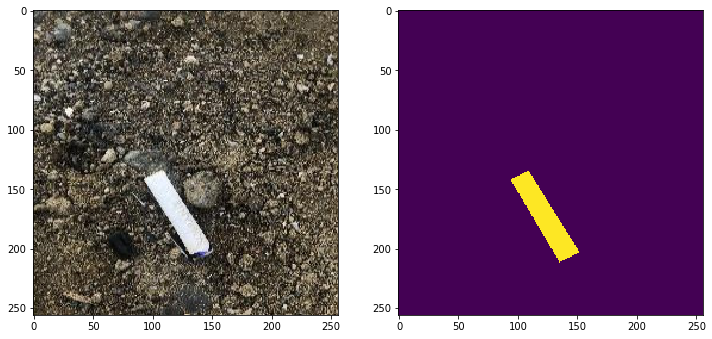

In [4]:
'''
Test with one image and mask
'''

json_files = os.listdir(config.MASK_DIRECTORY)
index = 20

mask_file = os.path.join(config.MASK_DIRECTORY, json_files[index])
jpg_file = mask_file.split('/')[-1].split('.')[0]
jpg_file = os.path.join(config.IMAGE_DIRECTORY, jpg_file+'.jpg')

img = plt.imread(jpg_file)
mask = np.load(mask_file)
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)


['IMG_6564.jpg', '00000103.jpg', 'IMG_6567.jpg', '00000550.jpg', 'IMG_6331.jpg'] ['00000609.npy', '00000587.npy', 'IMG_20200306_164230.npy', 'IMG_6396.npy', 'IMG_20200307_164356.npy']


In [4]:
'''
Add to database
'''
db = Dataset(config.DB_PATH)
# for file in os.listdir(config.IMAGE_DIRECTORY):
#     extension = file.split('/')[-1].split('.')[-1]
#     file_name = file.split('/')[-1].split('.')[0]
#     if extension == 'json':
#         json_file = os.path.join(config.IMAGE_DIRECTORY, file)
#         jpg_file = os.path.join(config.IMAGE_DIRECTORY, file_name+'.jpg')
#         mask_file = os.path.join(config.MASK_DIRECTORY, file_name+'.npy') 
#         db.add_Paths(jpg_file, mask_file, json_file, db.con)




In [71]:
'''
Load paths to list in the format of tuples
'''
util = Utils(db.load_paths(db.con, 609)) # we have 609 images in database
train_ds = util.load_images()
random.shuffle(train_ds)

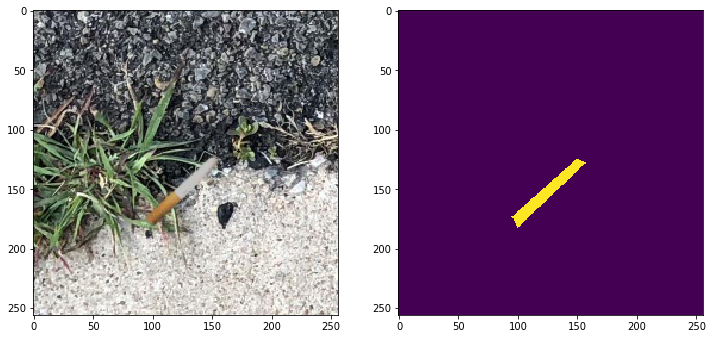

In [7]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(train_ds[0][0])
ax[1].imshow(train_ds[0][1])


In [73]:
'''fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)

Augment train data
'''

def augment(init_step, train_ds, nb_augment, augment_method):
    for count in range(nb_augment): 
        train_ds.append(augment_method(train_ds[init_step+count][0], train_ds[init_step+count][1]))    
    return train_ds


In [74]:
tr_ds = augment(0, train_ds, 500, flip_augment)
tr_ds = augment(500, train_ds, 600, rotate_augment)

In [75]:
len(tr_ds)

1709

In [ ]:
nb_flip_augment = 300
nb_rotate_augment = 500
for count in range(nb_flip_augment): 
    train_ds.append(flip_augment(train_ds[count][0], train_ds[count][1]))

In [6]:
for count in range(nb_rotate_augment):
    train_ds.append(rotate_augment(train_ds[count+nb_flip_augment][0], train_ds[count+nb_flip_augment][1]))

In [7]:
len(train_ds)

1409

In [8]:
def view_img_mask(img, mask):
    fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
    ax[0].imshow(img)
    ax[1].imshow(mask)

In [5]:
import os
import sys
import time
import random
import pprint
from collections import OrderedDict

import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



class CustomMetrics(Callback):
    def __init__(self, model, X_val, y_val, num_thresholds):
        super(CustomMetrics, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.num_thresholds = num_thresholds

    def on_epoch_end(self, epoch, logs={}):
        num_thresholds = self.num_thresholds
        thresholds = [(i + 1) * 1.0 / (num_thresholds - 1) for i in range(num_thresholds - 2)]
        custom_val_metrics = list()

        y_pred = tf.reshape(self.model.predict(self.X_val), [-1])
        y_true = tf.reshape(self.y_val, [-1])

        for thresh in thresholds:
            pred_classes = tf.cast(tf.math.greater(y_pred, tf.constant([thresh])), dtype=tf.float32)
            cm = tf.math.confusion_matrix(y_true, pred_classes, num_classes=2)

            tn = cm[0][0].numpy()
            fp = cm[0][1].numpy()
            fn = cm[1][0].numpy()
            tp = cm[1][1].numpy()

            precision = tp / (tp + fp + K.epsilon())
            recall = tp / (tp + fn + K.epsilon())
            f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

            payload = \
                OrderedDict([('val_auc', logs.get('val_auc')),
                             ('val_f1', f1),
                             ('precision', precision),
                             ('recall', recall),
                             ('val_tp', tp),
                             ('val_tn', tn),
                             ('val_fp', fp),
                             ('val_fn', fn),
                             ('thresh', thresh)])

            custom_val_metrics.append(payload)
        best_val_f1 = sorted(custom_val_metrics, key=lambda x: x['val_f1'], reverse=True)[0]
        pprint.pprint(best_val_f1)

        

In [6]:

def get_model(data, name="UNET-BASE", **params):
    def _get_log_weight_dirs(name, dt):
        _dt = dt.strftime("%Y_%m_%d_T%H_%M_%S")
        relative_dt_dir = os.path.join(name, _dt)
        dt_dir = os.path.join(config.MODEL_OUT_DIR, relative_dt_dir)
        return os.path.join(dt_dir, 'logs'), os.path.join(dt_dir, 'weights')


    start_filter = params.get('START_FILTER')
    middle_filter = params.get('MIDDLE_FILTERS')
    drop_rate = params.get('DROP_RATE')
    epochs = params.get('EPOCHS')
    batch_size = params.get('BATCH_SIZE')
    num_thresholds = params.get('NUM_THRESHOLDS')


    assert np.mod(np.log2(start_filter), 1) == 0.0
    assert np.mod(np.log2(middle_filter), 1) == 0.0
    assert middle_filter >= start_filter

    depth = np.int(np.log2(middle_filter) - np.log2(start_filter))
    
    (tr_ds, mask_ds),(val_ds, val_mask_ds) = split_train_val(train_ds)
    
    
    X_train = tf.cast(np.array(tr_ds), tf.float32)
    y_train = tf.cast(mask_ds, tf.float32)
    X_val = tf.cast(np.array(val_ds), tf.float32)
    y_val = tf.cast(val_mask_ds, tf.float32)


    input_channels = X_train.shape[-1]
    output_channels = y_train.shape[-1]

    weight_dir = config.MODEL_OUT
    log_dir = config.MODEL_OUT
    weight_path = str(os.path.join(weight_dir, 'weight.h5'))

    inputs = Input(shape=(config.IMG_WIDTH, config.IMG_HEIGHT, 3), name="inputs")
    temp = Lambda(lambda x: x / config.IMG_MAX_VAL, name="normalize")(inputs)

    k_init = tf.initializers.glorot_normal(seed=313)
    b_init = tf.initializers.glorot_normal(seed=313)
    dconvs = list()

    i = 0
    for i in range(depth):
        dconv_1 = Conv2D(filters=start_filter * np.power(2, i), kernel_size=(3, 3), strides=1, padding='same',
                         activation='relu', kernel_initializer=k_init, bias_initializer=b_init,
                         name=f'dconv_1_level_{i}')(temp)
        dconv_2 = Conv2D(filters=start_filter * np.power(2, i), kernel_size=(3, 3), strides=1, padding='same',
                         activation='relu', kernel_initializer=k_init, bias_initializer=b_init,
                         name=f'dconv_2_level_{i}')(dconv_1)
        dconvs.append(dconv_2)
        pool = MaxPooling2D((2, 2))(dconv_2)
        drop = Dropout(drop_rate, seed=313)(pool)
        temp = drop

    convm_1 = Conv2D(filters=start_filter * np.power(2, i + 1), kernel_size=(3, 3), strides=1, padding='same',
                     activation='relu', kernel_initializer=k_init, bias_initializer=b_init, name='convm_1')(temp)
    convm_2 = Conv2D(filters=start_filter * np.power(2, i + 1), kernel_size=(3, 3), strides=1, padding='same',
                     activation='relu', kernel_initializer=k_init, bias_initializer=b_init, name='convm_2')(convm_1)

    temp = convm_2
    for i in range(depth - 1, -1, -1):
        deconv = Conv2DTranspose(start_filter * np.power(2, i), (4, 4), strides=(2, 2), padding="same",
                                 kernel_initializer=k_init, bias_initializer=b_init, name=f'deconv_level_{i}')(temp)
        concat = concatenate([deconv, dconvs.pop()], name=f'concat_level_{i}')
        drop = Dropout(drop_rate, seed=313)(concat)
        uconv_1 = Conv2D(start_filter * np.power(2, i), (3, 3), activation="relu", padding="same",
                         kernel_initializer=k_init, bias_initializer=b_init, name=f'uconv_1_level_{i}')(drop)
        uconv_2 = Conv2D(start_filter * np.power(2, i), (3, 3), activation="relu", padding="same",
                         kernel_initializer=k_init, bias_initializer=b_init, name=f'uconv_2_level_{i}')(uconv_1)
        temp = uconv_2

    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid", kernel_initializer=k_init,
                     bias_initializer=b_init, name="outputs")(temp)

    model = Model(inputs=inputs, outputs=outputs)


    auc = AUC(num_thresholds=num_thresholds, curve='PR', name='auc')
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[auc])

    tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    model_checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1,
                                       save_weights_only=True)
    custom_metrics = CustomMetrics(model, X_val, y_val, num_thresholds)

    history = model.fit(X_train, y_train,
                        validation_data=[X_val, y_val],
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint, reduce_lr, custom_metrics, tensorboard_callback],
                        shuffle=False,
                        verbose=1)

    model.load_weights(weight_path)


    return history, model


In [7]:
def split_train_val(data):
    '''
    Splitting the data into train and validation set for u-net segmentation model.
    Args: 
        data
    Returns:
        (tr_ds, mask_ds), (val_ds, mask_val_ds)
    '''

    data_len = len(data)
    tr_len = int(data_len * 0.75)
    val_len = data_len - tr_len

    tr_ds = list()
    mask_ds = list()
    for i in range(tr_len):
        tr_ds.append(train_ds[i][0])
        mask_ds.append(train_ds[i][1])
    mask_ds = np.array(mask_ds).reshape(tr_len, config.IMG_HEIGHT, config.IMG_WIDTH, 1)


    val_ds = list()
    val_mask_ds = list()
    for i in range(val_len):
        val_ds.append(train_ds[tr_len+i][0])
        val_mask_ds.append(train_ds[tr_len+i][1])
    val_mask_ds = np.array(val_mask_ds).reshape(val_len, config.IMG_HEIGHT, config.IMG_WIDTH, 1)
    
    
    return (tr_ds, mask_ds), (val_ds, val_mask_ds)




In [12]:
(tr, mask),(val, val_mask) = split_train_val(train_ds)

list

In [14]:

UNET_CONFIG = {
    'START_FILTER': 16,
    'MIDDLE_FILTERS': 256,
    'DROP_RATE': 0.3,
    'EPOCHS': 30,
    'BATCH_SIZE': 32,
    'NUM_THRESHOLDS': 50
}


base_model = get_model(train_ds, **UNET_CONFIG)
# dt = np.array(train_ds[0][0])

<dtype: 'float32'>
Train on 900 samples, validate on 300 samples
Epoch 1/30
896/900 [============================>.] - ETA: 1s - loss: 0.1815 - auc: 0.0158
Epoch 00001: val_loss improved from inf to 0.09468, saving model to /home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/weight.h5
OrderedDict([('val_auc', 0.016091913),
             ('val_f1', 0.00014839174890589088),
             ('precision', 0.0001566400704879806),
             ('recall', 0.00014105864513167205),
             ('val_tp', 48),
             ('val_tn', 19014129),
             ('val_fp', 306387),
             ('val_fn', 340236),
             ('thresh', 0.04081632653061224)])
900/900 [==============================] - 360s 400ms/sample - loss: 0.1811 - auc: 0.0158 - val_loss: 0.0947 - val_auc: 0.0161
Epoch 2/30
896/900 [============================>.] - ETA: 1s - loss: 0.0831 - auc: 0.0267
Epoch 00002: val_loss improved from 0.09468 to 0.07194, saving model to /home/elmar/Cigarette_buts_detection/cigarette_

In [ ]:
tr_ds = list()
mask_ds = list()

for i in range(len(train_ds)):
    tr_ds.append(train_ds[i][0])
    mask_ds.append(train_ds[i][1])

In [ ]:
dt = np.array(tr_ds)
mask = np.array(mask_ds)

In [8]:

from tensorflow.keras.models import load_model
# base_model[1].save('auc_83.h5')
base_model = load_model('/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/model/out/auc_83.h5')

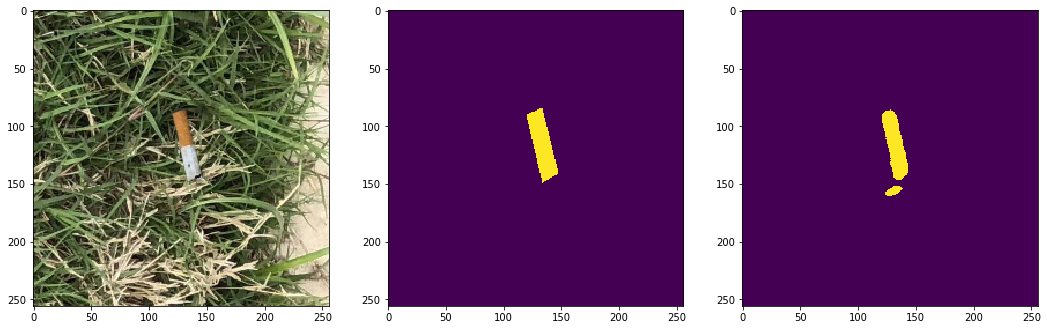

In [83]:
def view_img_mask(img, mask , model=None):
    if model:
        pred = model.predict(np.expand_dims(img, axis=0)).reshape((1, img.shape[0], img.shape[1], 1))
        pred = np.squeeze(pred)
        fig, ax = plt.subplots(1 , 3, figsize=(18, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)
        ax[2].imshow(pred >  0.32653061224489793)
    else:
        fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
        ax[0].imshow(img)
        ax[1].imshow(mask)

img_index = 83
view_img_mask(train_ds[img_index][0], train_ds[img_index][1], base_model)

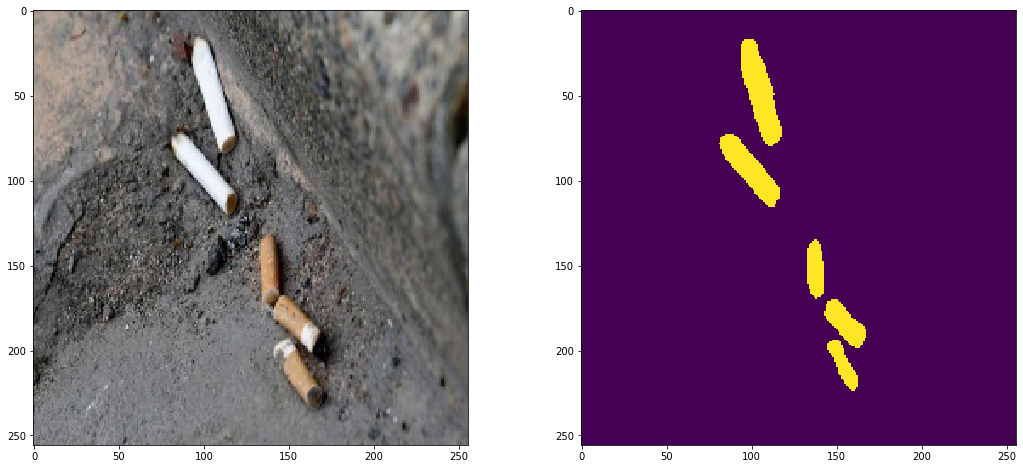

In [69]:
# predict on a test image
img = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-2.jpg')
pred = base_model.predict(np.expand_dims(img, axis=0)).reshape((1, 256, 256, 1))
pred = np.squeeze(pred)
cv2.imwrite('pred_test_2.jpg', (pred > 0.38).astype(float) *255 )
fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
ax[0].imshow(img)
ax[1].imshow(pred > 0.38)

In [87]:
def predict_img(img_path):
    # img = plt.imread('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-9.jpg')
    resize_image('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test')
    img = plt.imread(img_path)
    pred = base_model.predict(np.expand_dims(img, axis=0)).reshape((1, config.IMG_WIDTH, config.IMG_HEIGHT, 1))
    pred = np.squeeze(pred)
    fig, ax = plt.subplots(1 , 2, figsize=(18, 8))
    ax[0].imshow(img)
    ax[1].imshow(pred > 0.38)


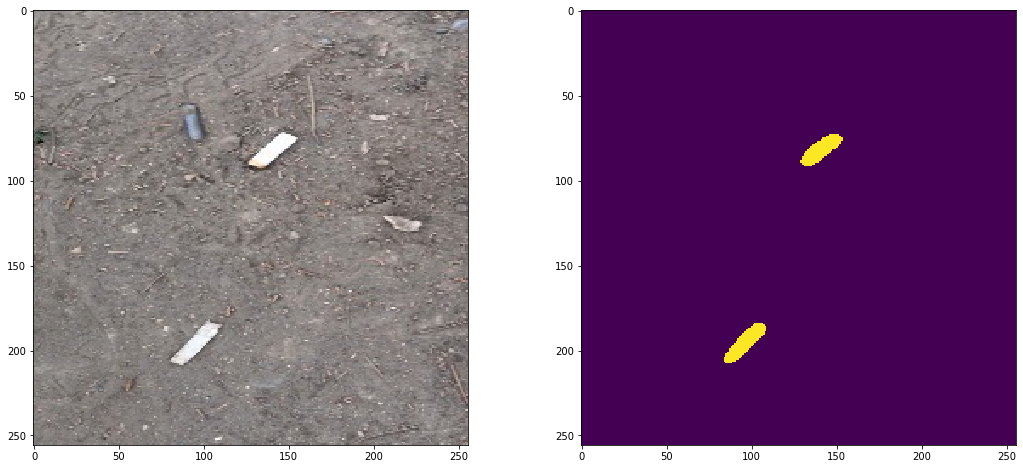

In [95]:
import cv2
predict_img('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/test-11.jpg')

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13878245001252609773
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10511054606790540847
physical_device_desc: "device: XLA_CPU device"
]


In [73]:
def video_predict(file_path, model, thresh_val):
    '''
    Read video and predict on each frame.
    Args:
        filename(str)
    '''
    def getFrame(sec):
        video_path = '/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test'
        vidcap = cv2.VideoCapture(file_path)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            image = cv2.resize(image, (256, 256))
            pred_img = base_model.predict(np.expand_dims(image, axis=0)).reshape((1, config.IMG_WIDTH, config.IMG_HEIGHT, 1))
            pred_img = np.squeeze(pred_img)
            cv2.imwrite(os.path.join(video_path,"pred_image"+str(count)+".jpg"), (pred_img > 0.38).astype(float) * 255)
            cv2.imwrite(os.path.join(video_path,"image"+str(count)+".jpg"), image)

        return hasFrames

    sec = 0
    frameRate = 0.5 #//it will capture image in each 0.5 second
    count = 1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)


In [74]:
video_predict('/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/test/img_9383.mp4', base_model , 0.38)